In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy import io, signal, stats
import sys, os
sys.path.append('../')

import pandas as pd
from sklearn.decomposition import PCA
import fooof
from fooof import FOOOFGroup
from seaborn import despine

from galaxybrain.data_utils import load_mouse_data, return_pops
from galaxybrain import ramsey 
from neurodsp.spectral import compute_spectrum

import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)
matplotlib.rc('figure', max_open_warning = 0)

In [2]:
datafolder = '../data/spikes/'
#datafolder = '/Users/rdgao/Documents/data/Stringer_neuropixel/spikes/'

all_mice = []
for i_m in range(3):
    print('Mouse ' + (str(i_m+1)))
    all_mice.append([])
    df_spk, df_info = load_mouse_data(datafolder, i_m, return_type='binned', bin_width=1)
    region_indices = {}
    for region in df_info.region.unique():
        region_indices.update({region:np.where(df_info['region'] == str(region))[0]})
        
    spk_list, region_labels = return_pops(df_spk, df_info)
    print(list(zip(region_labels, [s.shape[1] for s in spk_list])), 'Total:',sum([s.shape[1] for s in spk_list]))
    
    su_start_ind = len(region_labels)+1
    
    all_mice[i_m].append(df_spk[df_spk.columns[su_start_ind:]])
    all_mice[i_m].append(region_indices)
    
krebs = all_mice[0]; robbins = all_mice[1]; waksman = all_mice[2]

Mouse 1
Grabbing Spikes...
Binning Spikes...
[('CP', 176), ('FrMoCtx', 78), ('HPF', 265), ('LS', 122), ('MB', 127), ('SC', 42), ('SomMoCtx', 91), ('TH', 227), ('V1', 334)] Total: 1462
Mouse 2
Grabbing Spikes...
Binning Spikes...
[('FrCtx', 31), ('FrMoCtx', 647), ('HPF', 333), ('LS', 133), ('MB', 40), ('RSP', 112), ('SC', 98), ('SSCtx', 50), ('SomMoCtx', 220), ('TH', 638), ('UNK', 11), ('V1', 251), ('V2', 124)] Total: 2688
Mouse 3
Grabbing Spikes...
Binning Spikes...
[('CP', 134), ('FrMoCtx', 86), ('HPF', 155), ('LH', 4), ('LS', 4), ('RSP', 10), ('SomMoCtx', 10), ('TH', 1878), ('UNK', 15)] Total: 2296


In [ ]:
i_mouse = 0
all_mice[0][0]

/Users/brianbarry/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in log10


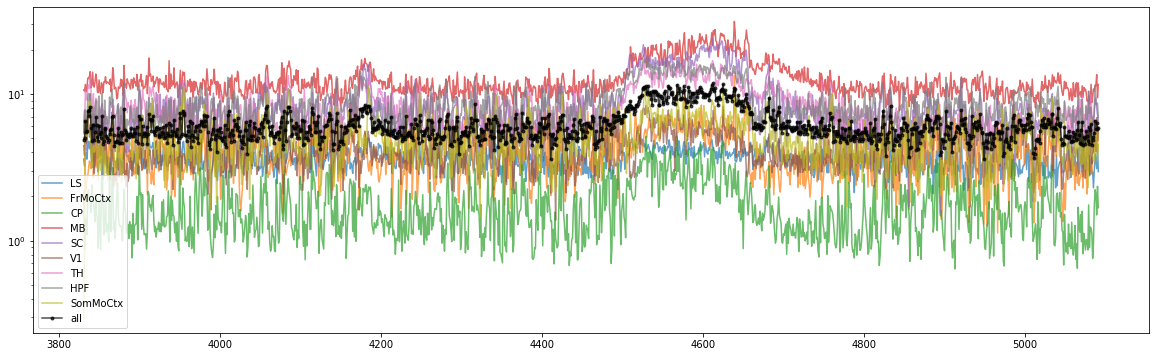

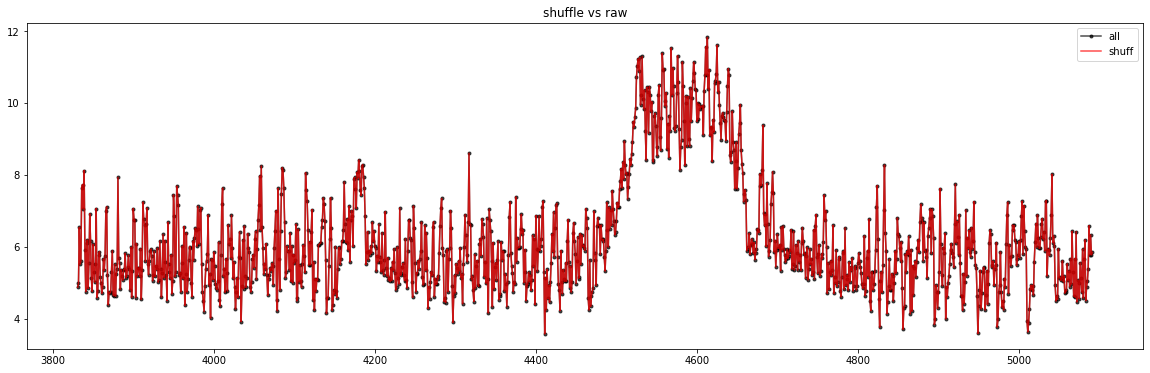

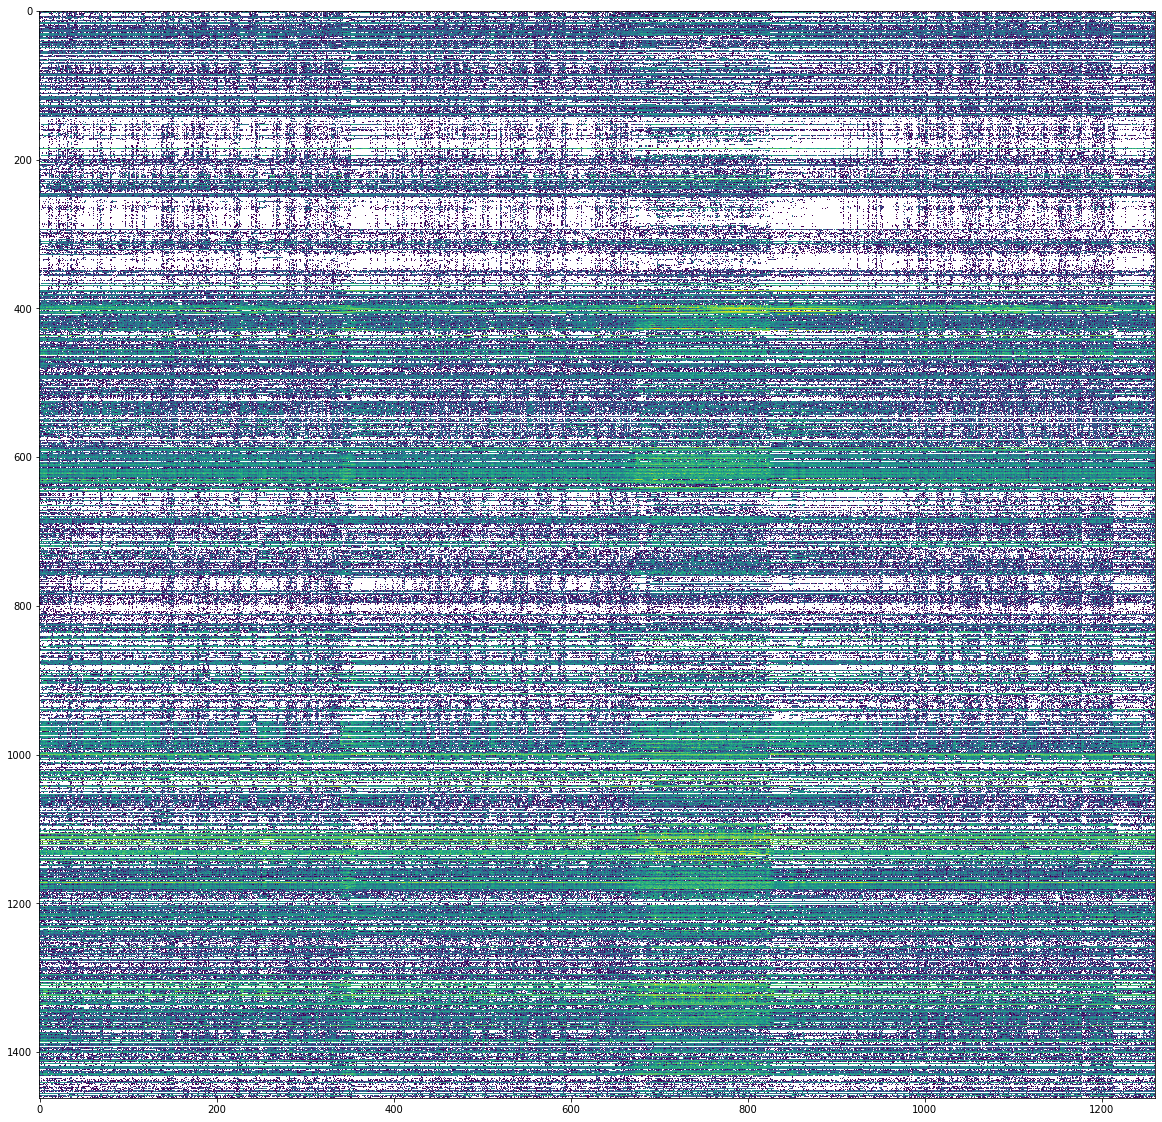

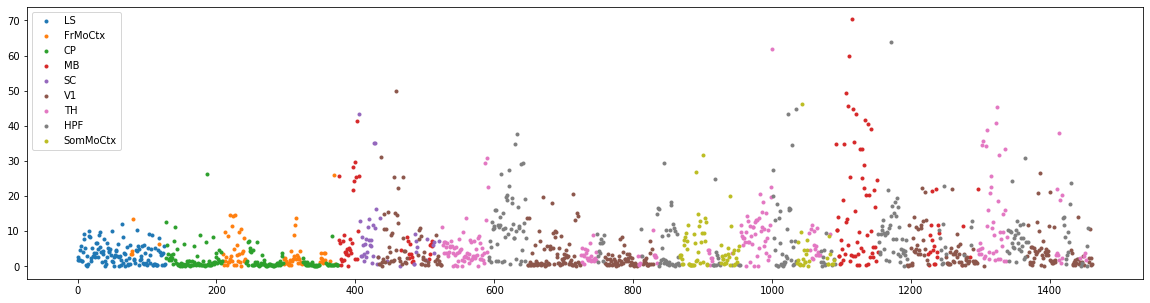

In [9]:
from galaxybrain.analysis_pipe import shuffle_data as shuffle_data
# check over time
i_mouse = 0
burn_in = 20
# total spikes over time
plt.figure(figsize=(20,6))
for k,v in all_mice[i_mouse][1].items():
    # normalize by number of cells present
    plt.plot(all_mice[i_mouse][0].index[burn_in:-burn_in], all_mice[i_mouse][0][v].sum(1).values[burn_in:-burn_in]/len(v), '-', label=k,alpha=0.7)
plt.plot(all_mice[i_mouse][0].index[burn_in:-burn_in], all_mice[i_mouse][0].sum(1).values[burn_in:-burn_in]/all_mice[i_mouse][0].shape[1], 'k.-', label='all', alpha=0.7)
plt.legend()
plt.yscale('log')

plt.figure(figsize=(20,6))
shuffled = shuffle_data(all_mice[i_mouse][0],'space')
plt.plot(all_mice[i_mouse][0].index[burn_in:-burn_in], all_mice[i_mouse][0].sum(1).values[burn_in:-burn_in]/all_mice[i_mouse][0].shape[1], 'k.-', label='all', alpha=0.7)
plt.plot(shuffled.index[burn_in:-burn_in], shuffled.sum(1).values[burn_in:-burn_in]/shuffled.shape[1], 'red', label='shuff', alpha=0.7)
plt.title('shuffle vs raw')
plt.legend()


#plt.xlim([4500, 4800])

plt.figure(figsize=(20,20))
plt.imshow(np.log10(np.array(all_mice[i_mouse][0]))[burn_in:-burn_in,:].T, aspect='auto')
#plt.colorbar()

# check over cells
plt.figure(figsize=(20,5))
for k,v in all_mice[i_mouse][1].items():
    plt.plot(v, all_mice[i_mouse][0][v].mean(0), '.', label=k)

#plt.yscale('log')
plt.legend()

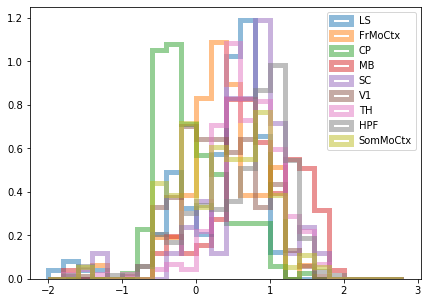

In [97]:
i_mouse=0
plt.figure(figsize=(7,5))
for k,v in all_mice[i_mouse][1].items():
    plt.hist(np.log10(all_mice[i_mouse][0][v].mean(0)), bins=np.arange(-2,3,0.2), label=k, density=True, alpha=0.5, lw=5,histtype='step')
    
#plt.hist(np.log10(all_mice[i_mouse][0].mean(0)), bins=np.arange(-2,3,0.2), label='all', color='k', density=True, alpha=0.5)
plt.legend()

In [245]:
i_mouse = 1
subset_size = 150
n_pc = int(0.9*subset_size)

data = np.array(all_mice[i_mouse][0])[burn_in:-burn_in]
print(data.shape)
pca = PCA(n_components=n_pc)
rand_inds = np.sort(np.random.choice(data.shape[1], subset_size, replace=False))
data_subset = data[:,rand_inds]

# DONT TRANSPOSE DATA MATRIX TO HAVE THE CORRECT TIME DIMENSIONS
pca.fit(data_subset)


f_axis, psd = compute_spectrum(data_subset.mean(1), fs=1, nperseg=120, noverlap=60, avg_type='mean')

(2446, 2688)


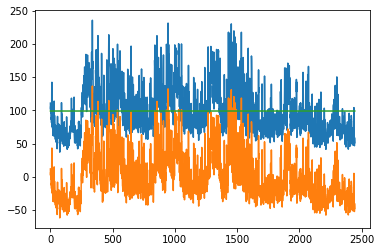

In [261]:
X_proj = pca.fit_transform(data_subset)

# X transformed (X_proj) is the same as X@pca.components_, (pca.components_ are the eigenvectors)
# plt.plot((data_subset@pca.components_.T)[:,0])
# plt.plot(X_proj[:,0])
# plt.plot((data_subset@pca.components_.T)[:,0]-X_proj[:,0])

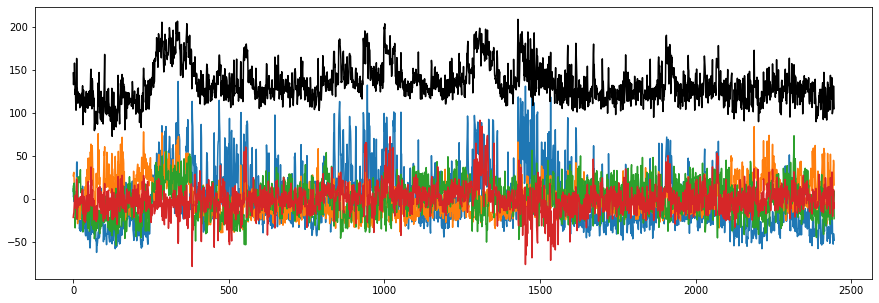

In [270]:
from scipy.stats import zscore
pca.fit(data_subset.T)
pca.components_.shape
plt.figure(figsize=(15,5))
plt.plot(X_proj[:,0:4])
#plt.plot(pca.components_[:1].T, alpha=0.8)
plt.plot(data_subset.mean(1)*20, 'k-')

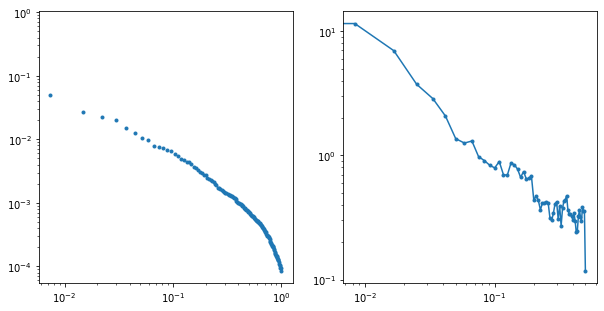

In [220]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.loglog(np.arange(n_pc)/n_pc, pca.explained_variance_ratio_, '.')
plt.subplot(1,2,2)
plt.loglog(f_axis, psd, '.-')

notes: 
- when n_pc is close to subset size, the last few eigenvalues become very small
- **crazy**: random.choice() chooses with replacement, which repeats some indices, hence enforcing the eigenvalues to be VERY small (near zero) for high subset size
    - solution: in random.choice(replace=False)
- fit up to 200 eigenvalues maximum or 50th percentile of the e-vales
    - question: is the slow roll-off at higher evals interesting or not?
    - PLOT the eigenspectrum plot where the xaxis is not the rank of PC, but proportion of n_pc (i.e., 0 to 1)
- NEVERMIND[TRANSPOSE DATA MATRIX TO HAVE THE CORRECT TIME DIMENSIONS]